In [84]:
import sklearn
import matplotlib.pyplot as plt
import matplotlib as mlp
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import copy

In [152]:
class GradientDescent:
    
    #gobal variable to store the num of iterations that continuesly yiels the same validation error
    #counter=0
    def __init__(self, eta=0.01, epochs=100, momentum=0.9,
                 l2=0.0,
                 minibatches=1,
                 n_classes=None,
                 random_seed=None):

        self.eta = eta            #learning rate
        self.epochs = epochs
        self.l2 = l2
        self.minibatches = minibatches
        self.n_classes = n_classes
        self.random_seed = random_seed
        self.momentum=momentum
        self.valacc = []
        self.T = 20    #Early stopping
        #self.counter=0


    def _fit(self, X, y, x_val, y_val, init_params=True):
        if init_params:
            if self.n_classes is None:
                self.n_classes = np.max(y) + 1
            self._n_features = X.shape[1]

            self.b_, self.w_ ,self.vw_,self.vb_= self._init_params(
                weights_shape=(self._n_features, self.n_classes),
                bias_shape=(self.n_classes,),
                random_seed=self.random_seed)
            self.cost_ = []

        y_enc = self._one_hot(y=y, n_labels=self.n_classes, dtype=np.float)
        counter=0

        for i in range(self.epochs):
            for idx in self._yield_minibatches_idx(n_batches=self.minibatches, data_ary=y, shuffle=True):
                # givens:
                # w_ -> n_feat x n_classes
                # b_  -> n_classes

                # net_input, softmax and diff -> n_samples x n_classes:
                net = self._net_input(X[idx], self.w_, self.b_)
                softm = self._softmax(net)
                diff = softm - y_enc[idx]
                mse = np.mean(diff, axis=0)

                # gradient -> n_features x n_classes
                grad = np.dot(X[idx].T, diff)/X[idx].shape[0]
                
                # update in opp. direction of the cost gradient
                self.vw_=self.momentum*self.vw_+(1-self.momentum)*grad
                #self.vb_=self.momentum*self.vb_+(1-self.momentum)*grad
                self.w_-=self.eta*self.vw_
                #self.b_-=self.eta*self.vb_
                #self.w_ -= (self.eta * grad +
                            #self.eta * self.l2 * self.w_)
                #self.b_ -= (self.eta * np.sum(diff, axis=0))
                #print("w",self.w_)
                #print("b",self.b_)

            # compute cost of the whole epoch
            net = self._net_input(X, self.w_, self.b_)
            softm = self._softmax(net)
            cross_ent = self._cross_entropy(output=softm, y_target=y_enc)
            cost = self._cost(cross_ent)
            self.cost_.append(cost)

            # EARLY STOPPING HERE
            # Calculate Validation accuracy, when validation accuracy

            valpred = self._early_stopping(x_val)
            if self._if_valacc_changed(valpred, y_val,counter) == True:
                # early stop
                return self.w_, self.b_ 

        #print("retrurn",self.w_)
        return self.w_,self.b_


    def _net_input(self, X, W, b):
        return (X.dot(W) + b)

    def _softmax(self, z):
        return (np.exp(z.T) / np.sum(np.exp(z), axis=1)).T

    def _cross_entropy(self, output, y_target):
        return - np.sum(np.log(output) * (y_target), axis=1)

    def _cost(self, cross_entropy):
        L2_term = self.l2 * np.sum(self.w_ ** 2)
        cross_entropy = cross_entropy + L2_term
        return 0.5 * np.mean(cross_entropy)

    
    def _init_params(self, weights_shape, bias_shape=(1,), dtype='float64',
                     scale=0.01, random_seed=None):
        """Initialize weight coefficients."""
        if random_seed:
            np.random.seed(random_seed)
        w=np.zeros(shape=weights_shape)
        #w = np.random.normal(loc=0.0, scale=scale, size=weights_shape)
        b = np.zeros(shape=bias_shape)
        v_w=np.zeros(shape=weights_shape)
        v_b=np.zeros(shape=bias_shape)
        return b.astype(dtype), w.astype(dtype),v_w.astype(dtype),v_b.astype(dtype)
    
    def _one_hot(self, y, n_labels, dtype):
        mat = np.zeros((len(y), n_labels))
        for i, val in enumerate(y):
            mat[i, val] = 1
        return mat.astype(dtype)    
    
    def _yield_minibatches_idx(self, n_batches, data_ary, shuffle=True):
        indices = np.arange(data_ary.shape[0])

        if shuffle:
            indices = np.random.permutation(indices)
        if n_batches > 1:
            remainder = data_ary.shape[0] % n_batches

            if remainder:
                minis = np.array_split(indices[:-remainder], n_batches)
                minis[-1] = np.concatenate((minis[-1],
                                            indices[-remainder:]),
                                            axis=0)
            else:
                minis = np.array_split(indices, n_batches)

        else:
            minis = (indices,)

        for idx_batch in minis:
            yield idx_batch
    
    def _shuffle_arrays(self, arrays):
        """Shuffle arrays in unison."""
        r = np.random.permutation(len(arrays[0]))
        return [ary[r] for ary in arrays]
    
    def _early_stopping(self, X):
        Nt = X.shape[0]
        X = np.column_stack([X,np.ones(Nt)])
        net = self._net_input(X, self.w_, self.b_)
        probas = self._softmax(net)
        return probas.argmax(axis=1)
    
    # # check that it hasn't CHANGED in 20 epochs
    # # i = epoch number
    # # valpred = label prediction
    # # y_val = target labels (so it's counting how many target labels are matching th eprediction)
    # def _if_valacc_changed(self, i, valpred, y_val):
    #     va = 0
    #     for index, yv in enumerate(y_val):
    #         if valpred[index] - yv == 0:
    #             va += 1   #Accuracy
    #     va = va/len(y_val)*100
    #     self.valacc.append(va)
    #     if i > self.T:
    #         if va == self.valacc[i-self.T]:
    #             return False

    #     return True
        

    #takes 2 params, check that it hasn't CHANGED in 20 epochs
    #       1. previousval : previous validation error
    #       2. currentval: current validation error
    def _if_valacc_changed(self,valpred, y_val,counter):
        for i in range(len(valpred)):
            if valpred[i]==y_val[i]:
                counter=counter+1

        if counter==20:
            return True
        else:
            return False
        

In [86]:
class SoftmaxRegression():
    def __init__(self, add_bias=True):
        self.add_bias = add_bias
        pass
        

    def fit(self, X, y, x_val, y_val, optimizer,init_params):
        Nt = X.shape[0]
        if self.add_bias:
            X = np.column_stack([X,np.ones(Nt)])
        
        self.w_,self.b_=optimizer._fit(X=X, y=y, x_val=x_val, y_val=y_val, init_params=init_params)
        self._is_fitted = True
        return self
    
    def _predict(self, X):
        Nt = X.shape[0]
        if self.add_bias:
            X = np.column_stack([X,np.ones(Nt)])
        probas = self.predict_proba(X)
        return self._to_classlabels(probas)
 
    def predict(self, X):
        if not self._is_fitted:
            raise AttributeError('Model is not fitted, yet.')
        return self._predict(X)

    def predict_proba(self, X):
        
        net = self._net_input(X, self.w_, self.b_)
        softm = self._softmax(net)
        #print("soft",softm,self.w_,self.b_)
        return softm

    def _net_input(self, X, W, b):
        return (X.dot(W) + b)

    def _softmax(self, z):
        return (np.exp(z.T) / np.sum(np.exp(z), axis=1)).T

    def _to_classlabels(self, z):
        return z.argmax(axis=1)


# fashion-MNIST dataset normalization 

In [128]:
from sklearn import preprocessing
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state
#import matplotlib as plt

le = preprocessing.LabelEncoder()
mnist = fetch_openml('mfeat-morphological',cache=True)
mnist_data=mnist.data
le.fit(mnist.target)

mnist_target=le.transform(mnist.target)
#mnist_target = mnist.target
# shuffle data
random_state = check_random_state(0)
permutation = random_state.permutation(mnist_data.shape[0])
mnist_data = mnist_data[permutation]
mnist_target = mnist_target[permutation]
mnist_data = mnist_data.reshape((mnist_data.shape[0], -1))

train_size = int(mnist_data.shape[0]*0.8)
test_size = mnist_data.shape[0]-train_size
# pick training and test data sets 
mnist_train_data, mnist_test_data, mnist_train_label, mnist_test_label = train_test_split(mnist_data,mnist_target,train_size=train_size,test_size=test_size)




/opt/venv/lib/python3.7/site-packages/sklearn/datasets/_openml.py:376: UserWarning: Multiple active versions of the dataset matching the name mfeat-morphological exist. Versions may be fundamentally different, returning version 1.
  " {version}.".format(name=name, version=res[0]['version']))


In [16]:
!pip install seaborn==0.11.0

     |████████████████████████████████| 283 kB 17.4 MB/s 


/opt/venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


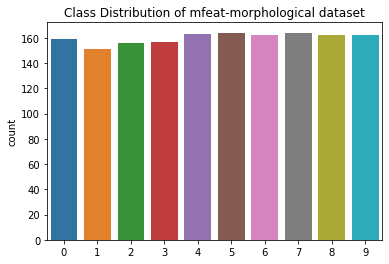

In [181]:
import seaborn as sns
g = sns.countplot(mnist_train_label).set_title("Class Distribution of mfeat-morphological dataset")
g.figure.savefig("dataset.png")
#classes are evenly divided among the 10 classes.

https://towardsai.net/p/data-science/how-when-and-why-should-you-normalize-standardize-rescale-your-data-3f083def38ff

Normalization is a good technique to use when you do not know the distribution of your data or when you know the distribution is not Gaussian (a bell curve). Normalization is useful when your data has varying scales and the algorithm you are using does not make assumptions about the distribution of your data, such as k-nearest neighbors and artificial neural networks.

In [130]:
#In this approach, the data is scaled to a fixed range — usually 0 to 1.
#normalize features by minmax scaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 

mnist_train_data = scaler.fit_transform(mnist_train_data)
mnist_test_data = scaler.transform(mnist_test_data)


/opt/venv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


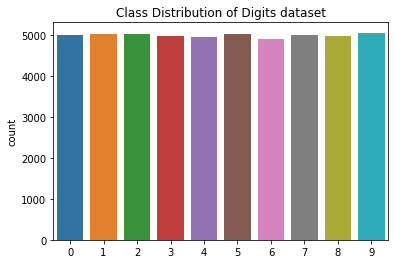

In [19]:
from sklearn.datasets import load_digits
digits = load_digits()

n_samples = len(digits.images)
digit_target=digits.target
digit_data = digits.images.reshape((n_samples, -1))
# shuffle data
random_state = check_random_state(0)
permutation = random_state.permutation(digit_data.shape[0])
digit_data = digit_data[permutation]
digit_target = digit_target[permutation]
digit_data = digit_data.reshape((digit_data.shape[0], -1))

train_size = int(digit_data.shape[0]*0.8)
test_size = digit_data.shape[0]-train_size
# pick training and test data sets 
digit_train_data, digit_test_data, digit_train_label, digit_test_label = train_test_split(digit_data,digit_target,train_size=train_size,test_size=test_size)
g2 = sns.countplot(mnist_train_label).set_title("Class Distribution of Digits dataset")
g2.figure.savefig("dataset2.png")
scaler2 = MinMaxScaler() 

digit_train_data = scaler2.fit_transform(digit_train_data)
digit_test_data = scaler2.transform(digit_test_data)

In [ ]:
#data variables
#digit_test_data, digit_test_label, digit_train_data,digit_train_label
#mnist_test_data,mnist_test_label,mnist_train_data,mnist_train_label

# HYPERPARAMETER OPTIMIZATION

Implement and use 5-fold cross validation to estimate performance, in terms of accuracy, in
all of the experiments with respect to batch sizes, learning rates, and momentum parameters, and report the best
hyper-parameters you found.


You should track and analyze the validation and training accuracy (and optionally
the cost) to better understand and analyze the effect of different hyper-parameters. Each fold in cross-validation
will produce one of these training and validation curves. Plot one of these training and validation curves for
several representative choices of hyper-parameters in your report.

"""
Yes, this sentence is confusing. To clarify: after you found out the optimal hyperparameters set, you can alter one hyperparameter at a time and plot the averaged cross validation training and validation accuracy/error. Then analyze the changes of performance on the hyperparameter you altered. 
"""

In [64]:

# https://towardsdatascience.com/grid-search-in-python-from-scratch-hyperparameter-tuning-3cca8443727b

from random import seed
from random import randrange
import numpy as np
import time

 
# Split a dataset into k folds
def cross_validation(hyperparams, dataset, targets, folds=5):
    

    dataset_split = []
    targets_split = []
    fold_size = int(len(dataset) / folds)
    start = 0
    for i in range(folds):
        dataset_split.append(dataset[start:start+fold_size])
        targets_split.append(targets[start:start+fold_size])
        start += fold_size

    x_train = []
    y_train = []
    x_test = []
    y_test = []
    accuracies = []
    t_acc = []
    v_acc = []
    time_list=[]

    for index in range(folds):
        x_test = np.array(dataset_split[index])
        y_test = np.array(targets_split[index])

        x_train = dataset_split[:index] + dataset_split[index+1:]
        x_train = np.array([item for items in x_train for item in items])
        y_train = targets_split[:index] + targets_split[index+1:]
        y_train = np.array([item for items in y_train for item in items])

        train_acc, val_acc,time_used = do_prediction(hyperparams, x_train, y_train, x_test, y_test)
        #print("Run: ", index+1, "Train Accuracy: ", train_acc)
        #print("Run: ", index+1, "Val Accuracy: ", val_acc)
        t_acc.append(train_acc)
        v_acc.append(val_acc)
        time_list.append(time_used)
     
    return np.mean(t_acc), np.mean(v_acc),np.mean(time_list)


def do_prediction(hyperparams, x_train, y_train, x_test, y_test):
    start_time = time.time()
    optimizer=GradientDescent(eta=hyperparams['eta'], epochs=100, minibatches=hyperparams['minibatches'], 
    momentum=hyperparams['momentum'], random_seed=0)
    lr = SoftmaxRegression()

    model = lr.fit(x_train, y_train, x_test, y_test, optimizer,True)
    training = model.predict(x_train)
    validation = model.predict(x_test)
    train_acc = 0
    val_acc = 0

    for index, y in enumerate(y_train):
        if training[index] - y == 0:
            train_acc += 1   #Accuracy
    
    for index, y in enumerate(y_test):
        if validation[index] - y == 0:
            val_acc += 1   #Accuracy

    train_acc = train_acc/len(y_train)*100
    val_acc = val_acc/len(y_test)*100
    time_used=time.time() - start_time
    #print('Time: ', time.time(),start_time,time.time() - start_time,hyperparams) 
    return train_acc, val_acc,time_used
 

# test cross validation split
#seed(1)

hyperparams = {
    'eta': 0.1,
    'minibatches':80,
    'momentum':0.9,
}

"""
from sklearn.datasets import load_digits
digits = load_digits()

n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

cross_validation(hyperparams, data, digits.target, 5)
#print(folds[0].shape)
#print(data.shape)
"""


"""
from sklearn.datasets import fetch_openml
from sklearn import preprocessing
#get iris dataset from openml
iris = fetch_openml(name='iris')

le = preprocessing.LabelEncoder()
n_samples = iris.target.shape[0]

iris_data = iris.data

# standardize
for i in range(4):
    data[:,i] = (data[:,i] - data[:,i].mean()) / data[:,i].std()

label_names=np.unique(iris.target)
le.fit(label_names)
label=le.transform(iris.target)
cross_validation(hyperparams, data, label, 5)
"""


#mnist_train_data, mnist_test_data, mnist_train_label, mnist_test_label


"\nfrom sklearn.datasets import fetch_openml\nfrom sklearn import preprocessing\n#get iris dataset from openml\niris = fetch_openml(name='iris')\n\nle = preprocessing.LabelEncoder()\nn_samples = iris.target.shape[0]\n\niris_data = iris.data\n\n# standardize\nfor i in range(4):\n    data[:,i] = (data[:,i] - data[:,i].mean()) / data[:,i].std()\n\nlabel_names=np.unique(iris.target)\nle.fit(label_names)\nlabel=le.transform(iris.target)\ncross_validation(hyperparams, data, label, 5)\n"

In [48]:
print("--- %s seconds ---" % time.time() )
end=time.time()
print("--- %s seconds ---" % (time.time()-end) )

--- 1606071996.295162 seconds ---
--- 3.838539123535156e-05 seconds ---


## Hyperparameters GRID SEARCH


Max Accuracy: 92.9248

Optimum eta: 0.010000

Optimum batch size: 10.000000

Optimum momentum: 0.900000

In [70]:
### GRID SEARCH CV
"""
        self.eta = eta            #learning rate
        self.epochs = epochs
        self.l2 = l2
        self.minibatches = minibatches
        self.n_classes = n_classes
        self.random_seed = random_seed
        self.momentum=momentum
"""

from sklearn.datasets import load_digits
digits = load_digits()

n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))


hyperparams = {
    'eta': [0.1, 0.05, 0.01, 0.5],
    'minibatches':[1,10,20, 50],
    'momentum':[0.9, 0.95, 0.99, 0.999],
}

#hyperparams = {
#    'eta': [0.01, 0.05, 0.1],
#    'minibatches':[1, 20, 50],
#    'momentum':[0.9, 0.95, 0.99],
#}

optimum_eta=0
optimum_batchsize=0
optimum_momentum=0

def GridSearch(X, Y):
    graph_t = np.zeros((4,4,4))
    graph_v = np.zeros((4,4,4))
    graph_w = np.zeros((4,4,4))
    graph_x = np.zeros((4,4,4))
    graph_y = np.zeros((4,4,4))
    graph_time=np.zeros((4,4,4))

    for ind1,eta in enumerate(hyperparams['eta']):
        
        for ind2,minibatches in enumerate(hyperparams['minibatches']):
           

            for ind3,momentum in enumerate(hyperparams['momentum']):
                params = {}
                params['eta'] = eta
                params['minibatches'] = minibatches
                params['momentum'] = momentum
                t_acc, v_acc,time_acc = cross_validation(params, X, Y, 5)
                graph_t[ind1][ind2][ind3]=t_acc
                graph_v[ind1][ind2][ind3]=v_acc
                graph_w[ind1][ind2][ind3]=eta
                graph_x[ind1][ind2][ind3]=minibatches
                graph_y[ind1][ind2][ind3]=momentum
                graph_time[ind1][ind2][ind3]=time_acc
                
            
        print('')
   

    max_v = np.max(graph_v)
    pos_max_v = np.argwhere(graph_v == np.max(graph_v))[0]
    
    optimum_eta=hyperparams['eta'][pos_max_v[0]]
    optimum_batchsize=hyperparams['minibatches'][pos_max_v[1]]
    optimum_momentum=hyperparams['momentum'][pos_max_v[2]]



    optimum_eta=(graph_w[pos_max_v[0],pos_max_v[1],pos_max_v[2]])
    optimum_batchsize= (graph_x[pos_max_v[0],pos_max_v[1],pos_max_v[2]])
    optimum_momentum= (graph_y[pos_max_v[0],pos_max_v[1],pos_max_v[2]])


    print('Max Accuracy: %.4f' %(max_v))
    print('Optimum eta: %f' % (optimum_eta))
    print('Optimum batch size: %f' % (optimum_batchsize))
    print('Optimum momentum: %f' % (optimum_momentum))

    return graph_t, graph_v, graph_w, graph_x,graph_y, graph_time
    

t, v, w, x, y,runtime = GridSearch(digit_train_data, digit_train_label)

### DIGITS DATASET
# Max Accuracy: 97.1429
#Optimum eta: 0.500000
#Optimum batch size: 50.000000
#Optimum momentum: 0.900000





Max Accuracy: 97.1429
Optimum eta: 0.500000
Optimum batch size: 50.000000
Optimum momentum: 0.900000


In [71]:
print(runtime)

[[[0.68531895 0.69972997 0.71635766 0.66889544]
  [1.01812749 1.03262687 1.00297446 1.01566882]
  [1.27940669 1.28064632 1.26272345 1.29510608]
  [2.03917875 2.06125817 2.09303732 2.0012352 ]]

 [[0.71488595 0.67500596 0.71457872 0.69882579]
  [1.03939924 1.01636467 1.01566582 1.0021574 ]
  [1.25415831 1.29828935 1.26865749 1.29412446]
  [2.03683825 2.0395164  2.06285491 2.05768976]]

 [[0.71124868 0.68153467 0.68255663 0.69015279]
  [1.00391026 1.01818204 1.01881132 0.99744492]
  [1.27746859 1.28341665 1.25974102 1.33669562]
  [2.05657187 1.9934391  2.05294032 2.07935328]]

 [[0.71910434 0.71874318 0.70555806 0.69941835]
  [1.01933794 1.01889825 1.03473058 1.01881285]
  [1.28073125 1.29366641 1.30269275 1.27982774]
  [2.07531762 2.07751122 2.04072061 2.21113572]]]


In [110]:
print(mnist_train_data.shape)
print(digit_train_data.shape)

(1848, 19)
(1437, 64)


In [132]:
t2,v2, w2, x2, y2,runtime2 = GridSearch(mnist_train_data, mnist_train_label)

#
#Max Accuracy: 71.5000
#Optimum eta: 0.500000
#Optimum batch size: 50.000000
#Optimum momentum: 0.950000





Max Accuracy: 71.5000
Optimum eta: 0.500000
Optimum batch size: 50.000000
Optimum momentum: 0.950000


In [106]:
# Iris Dataset Cross Validation
from sklearn.datasets import fetch_openml
from sklearn import preprocessing
#get iris dataset from openml
iris = fetch_openml(name='iris')

le = preprocessing.LabelEncoder()
n_samples = iris.target.shape[0]

iris_data = iris.data

# standardize
for i in range(4):
    iris_data[:,i] = (iris_data[:,i] - iris_data[:,i].mean()) / iris_data[:,i].std()

label_names=np.unique(iris.target)
le.fit(label_names)
iris_label=le.transform(iris.target)
t3,v3, w3, x3, y3,runtime3 = GridSearch(mnist_train_data, mnist_train_label)

#Max Accuracy: 96.7519
#Optimum eta: 0.500000
#Optimum batch size: 50.000000
#Optimum momentum: 0.950000

/opt/venv/lib/python3.7/site-packages/sklearn/datasets/_openml.py:376: UserWarning: Multiple active versions of the dataset matching the name iris exist. Versions may be fundamentally different, returning version 1.
  " {version}.".format(name=name, version=res[0]['version']))




Max Accuracy: 96.7519
Optimum eta: 0.500000
Optimum batch size: 50.000000
Optimum momentum: 0.950000


# Plotting Training and Validation curves as Hyperparameters Vary

Plot one of these training and validation curves for several representative choices of hyperparameters

""" Yes, this sentence is confusing. To clarify: after you found out the optimal hyperparameters set, you can alter one hyperparameter at a time and plot the averaged cross validation training and validation accuracy/error. Then analyze the changes of performance on the hyperparameter you altered. """

eta  value with the highest Validation Accuracy is:  0.45
###########################
minibatches  value with the highest Validation Accuracy is:  140
###########################
momentum  value with the highest Validation Accuracy is:  0.85
###########################
eta  value with the highest Validation Accuracy is:  0.45
###########################
minibatches  value with the highest Validation Accuracy is:  150
###########################
momentum  value with the highest Validation Accuracy is:  0.86
###########################
/opt/venv/lib/python3.7/site-packages/sklearn/datasets/_openml.py:376: UserWarning: Multiple active versions of the dataset matching the name iris exist. Versions may be fundamentally different, returning version 1.
  " {version}.".format(name=name, version=res[0]['version']))
eta  value with the highest Validation Accuracy is:  0.45
###########################
/opt/venv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of em

"\n#Varying_X series of png images for Iris Dataset\n#fixed = {\n#    'eta':0.01,\n#    'minibatches':10,\n#    'momentum':0.9\n#}\n#eta  value with the highest Validation Accuracy is:  0.25\n#minibatches  value with the highest Validation Accuracy is:  110\n#momentum  value with the highest Validation Accuracy is:  0.95\n"

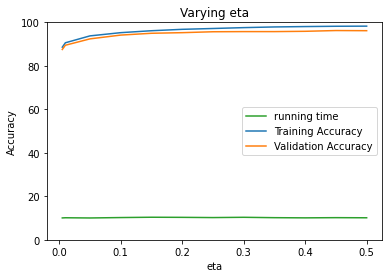

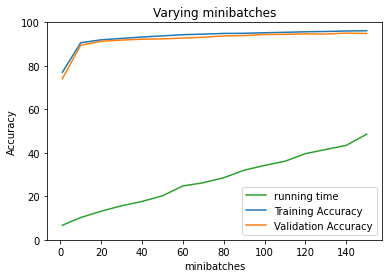

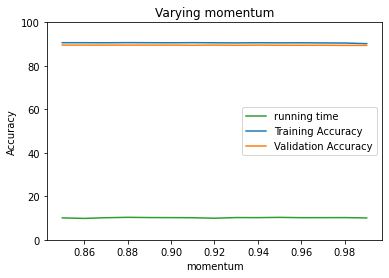

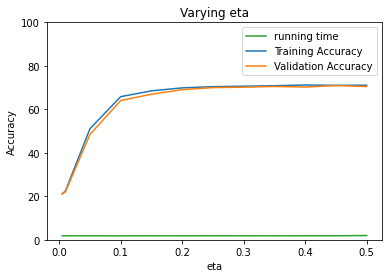

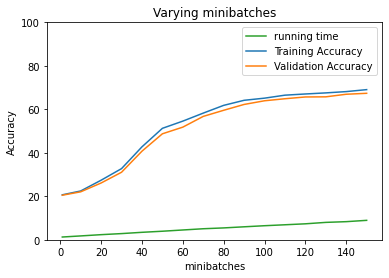

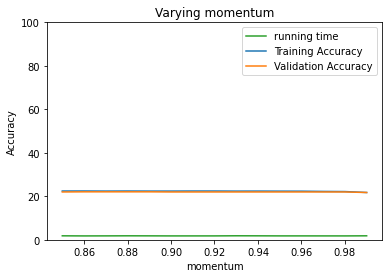

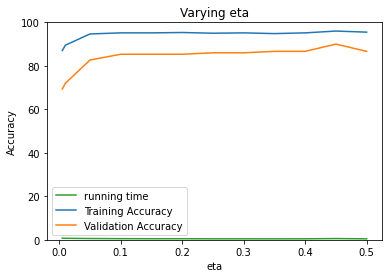

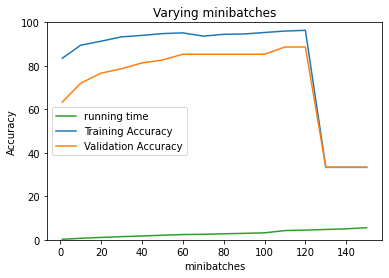

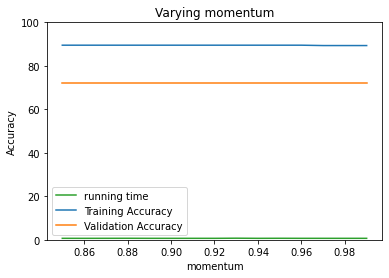

In [153]:
# Plotting Training and Validation curves

# p = value of hyperparameter that's being varied
# p_name = name of that hyperparameter (eta, minibatches, momentum)

def plot_train_val(name, hyperparams, fixed, X, Y):

    for hname in list(hyperparams.keys()):
        val_values = []
        train_values = []
        time_values=[]
        params = copy.deepcopy(fixed)
        for hvalue in hyperparams[hname]:
            params[hname] = hvalue
            t_acc, v_acc,time_acc = cross_validation(params, X, Y, 5)
            train_values.append(t_acc)
            val_values.append(v_acc)
            time_values.append(time_acc)
    
        time_values = [t*10 for t in time_values]
        plt.figure()
        plt.ylim(0, 100)
        plt.ylabel('Accuracy')
        plt.xlabel(hname)
        plt.title('Varying ' + hname)
        #plt.xticks(hyperparams[hname])
        plt.plot(hyperparams[hname], time_values, color='tab:green', label='Running Time')
        plt.plot(hyperparams[hname], train_values, color='tab:blue', label='Training Accuracy')
        plt.plot(hyperparams[hname], val_values, color='tab:orange', label='Validation Accuracy')
        plt.legend()

        plt.savefig(name + 'Varying_' + hname + '.png')

        max_val = np.max(val_values)
        pos_max_val = np.argwhere(val_values == np.max(val_values))[0][0]
        print(hname, " value with the highest Validation Accuracy is: ", hyperparams[hname][pos_max_val])

        print("###########################")


hyperparams = {
    'eta':[0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.40, 0.45, 0.5],
    'minibatches':[1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150],
    'momentum': [0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]
}

fixed = {
    'eta':0.01,
    'minibatches':10,
    'momentum':0.9
}


#DIGITS DATASET

from sklearn.datasets import load_digits
digits = load_digits()

n_samples = len(digits.images)
digits_data = digits.images.reshape((n_samples, -1))
plot_train_val("Digits", hyperparams, fixed, digit_train_data, digit_train_label)


# FASHION DATASET
plot_train_val("Fashion", hyperparams, fixed, mnist_train_data, mnist_train_label)

#

# standardize


#IRIS DATASET
from sklearn.datasets import fetch_openml
from sklearn import preprocessing
iris = fetch_openml(name='iris')

le = preprocessing.LabelEncoder()
n_samples = iris.target.shape[0]

iris_data = iris.data

for i in range(4):
    iris_data[:,i] = (iris_data[:,i] - iris_data[:,i].mean()) / iris_data[:,i].std()

iris_label_names=np.unique(iris.target)
le.fit(iris_label_names)
iris_label=le.transform(iris.target)
plot_train_val("Iris", hyperparams, fixed, iris_data, iris_label)



"""
Digits
eta  0.45
minibatches  value with the highest Validation Accuracy is:  140
momentum  value with the highest Validation Accuracy is:  0.85

Fashion
eta  value with the highest Validation Accuracy is:  0.45
minibatches  value with the highest Validation Accuracy is:  150
momentum  value with the highest Validation Accuracy is:  0.86

Iris
eta  value with the highest Validation Accuracy is:  0.45
minibatches  value with the highest Validation Accuracy is:  110
momentum  value with the highest Validation Accuracy is:  0.85

"""




# Comparsion against another classifier
#### data sets
    digits
    mfeat-morphological
#### classification
    KNN
    

#### KNN

In [112]:
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
from sklearn import datasets, neighbors
from sklearn.datasets import fetch_openml
'''mnist = fetch_openml('Fashion-MNIST', version=1, cache=True)
mnist_data=mnist.data
mnist_target=mnist.target

le = preprocessing.LabelEncoder()
n_samples = mnist.target.shape[0]
print(mnist.data.shape,mnist.target.shape)
data = mnist.data


# standardize
for i in range(4):
    data[:,i] = (data[:,i] - data[:,i].mean()) / data[:,i].std()

label_names=np.unique(mnist.target)
le.fit(label_names)
label=le.transform(mnist.target)'''
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(mnist_test_data, mnist_test_label, test_size=0.5, random_state=0, shuffle=True)

model = neighbors.KNeighborsClassifier(n_neighbors=5)
model = model.fit(x_train, y_train)

# compute classification accuracy for the logistic regression model
from sklearn import metrics
y_pred = model.predict(x_train)
print(metrics.accuracy_score(y_train, y_test))


0.13852813852813853


#### cross validation and tune hyperparameter
    to find the best k value

In [113]:
print(digit_train_data[0],digit_train_label[0])

[0.         0.         0.25       1.         0.0625     0.
 0.         0.         0.         0.         0.75       0.8125
 0.         0.0625     0.0625     0.         0.         0.1875
 1.         0.5        0.3125     1.         0.375      0.
 0.         0.6        1.         0.375      0.875      1.
 0.13333333 0.         0.         0.78571429 1.         1.
 1.         0.5625     0.         0.         0.         0.
 0.625      0.9375     0.9375     0.125      0.         0.
 0.         0.         0.1875     1.         0.5625     0.
 0.         0.         0.         0.         0.3125     1.
 0.1875     0.         0.         0.        ] 4


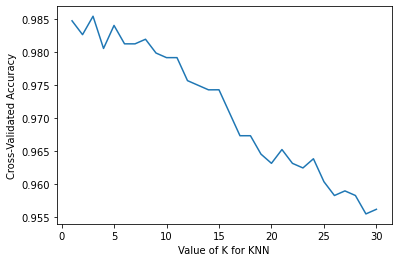

2


In [170]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt 
from sklearn.datasets import load_iris 
iris = load_iris()
X=digit_train_data
y=digit_train_label
k_range = range(1, 31)
k_scores = []
for k in k_range:
    
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=5, scoring='accuracy')
    k_scores.append(scores.mean())
# plot to see clearly

plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()
print(k_scores.index(max(k_scores)))

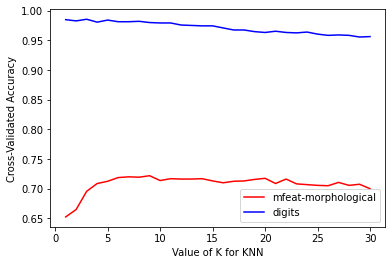

best k value for mfeat-morphological 9
best accuracy for mfeat-morphological 0.721875
best k value for digits 3
best accuracy for digits 0.9853755323267517


In [180]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt 
from sklearn.datasets import load_iris 
iris = load_iris()
#mnist_test_data,mnist_test_label,mnist_train_data,mnist_train_label
X=mnist_train_data
y=mnist_train_label
k_range1 = range(1, 31)
k_scores1 = []
for k in k_range1:
    
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=5, scoring='accuracy')
    k_scores1.append(scores.mean())
# plot to see clearly
k_range1=k_range1
k_scores1=k_scores1
# plt.plot(k_range, k_scores)
plt.figure()
plt.plot(k_range1, k_scores1, color="red", label='mfeat-morphological')
plt.plot(k_range, k_scores, color="blue", label='digits')
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.legend()
plt.show()
print("best k value for mfeat-morphological",k_range1[k_scores1.index(max(k_scores1))])
print("best accuracy for mfeat-morphological",k_scores1[k_scores1.index(max(k_scores1))])

print("best k value for digits",k_range[k_scores.index(max(k_scores))])
print("best accuracy for digits",k_scores[k_scores.index(max(k_scores))])

#### function for cross-validation on all possible combination of hyperparameteres

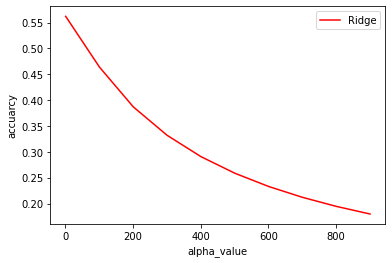

In [135]:
from sklearn.neighbors import KNeighborsClassifier
#from sklearn.linear_model import LinearRegression as Ridge
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt 
X=digit_train_data
y=digit_train_label
from sklearn.linear_model import RidgeCV

alpharange = np.arange(1, 1001, 100)
accuracy =  []
for a in alpharange:
    reg = Ridge(alpha=a).fit(x_train,y_train) 
    linear = LinearRegression()
    regs = cross_val_score(reg, X, y, cv=5, scoring="r2").mean()
    linears = cross_val_score(linear, X, y, cv=5, scoring="r2").mean()
    accuracy.append(regs)
   
plt.plot(alpharange, accuracy, color="red", label="Ridge")
# plt.plot(alpharange, lr, color="orange", label="LR")
plt.ylabel('accuarcy')
plt.xlabel('alpha_value')

plt.legend()
plt.show()



#### Ridge Regression

In [78]:
import numpy as np
from sklearn.linear_model import LinearRegression as LR,Ridge,Lasso
from sklearn.datasets import fetch_openml
mnist = fetch_openml('Fashion-MNIST', version=1, cache=True)
mnist_data=mnist.data
mnist_target=mnist.target
from sklearn import preprocessing
#get iris dataset from openml

le = preprocessing.LabelEncoder()
n_samples = mnist.target.shape[0]
print(mnist.data.shape,mnist.target.shape)
data = mnist.data

# standardize
for i in range(4):
    data[:,i] = (data[:,i] - data[:,i].mean()) / data[:,i].std()

label_names=np.unique(mnist.target)
le.fit(label_names)
label=le.transform(mnist.target)
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size=0.5, random_state=0, shuffle=True)


# ridge regression
reg = Ridge(alpha=100).fit(x_train,y_train) 


yhat = reg.predict(x_test)
from sklearn.metrics import r2_score
accuracy=r2_score(y_test,yhat) 
print(accuracy)


